# Playing around with the dataset~

In [1]:
#Imports
import numpy as np
import pandas as pd
import pylab as pb
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf as acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.tsa.api as smt
from scipy.optimize import leastsq

In [40]:
#Read data as panda.DataFrame
pdData = pd.read_csv('data/data10_19.csv', parse_dates=['SDATE'], index_col='SDATE')

#Also save as numpy array
npData = pdData.as_matrix();


/Users/Marcus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


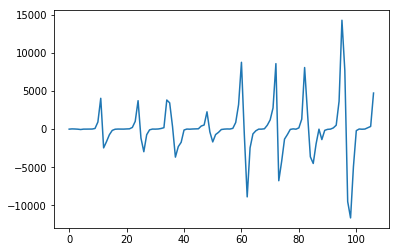

In [57]:
X = pdData.values
diff = list()
for i in range(1, len(X)):
	value = X[i] - X[i - 1]
	diff.append(value)
pb.plot(diff)
pb.show()

## Visualize data and remove trends/cycles

###### Raw data with mean, trend removed etc.

###### Residuals after polyfit, 2nd and 3rd degree polynomials

In [43]:
pdData[0]

KeyError: 0

KeyError: 0

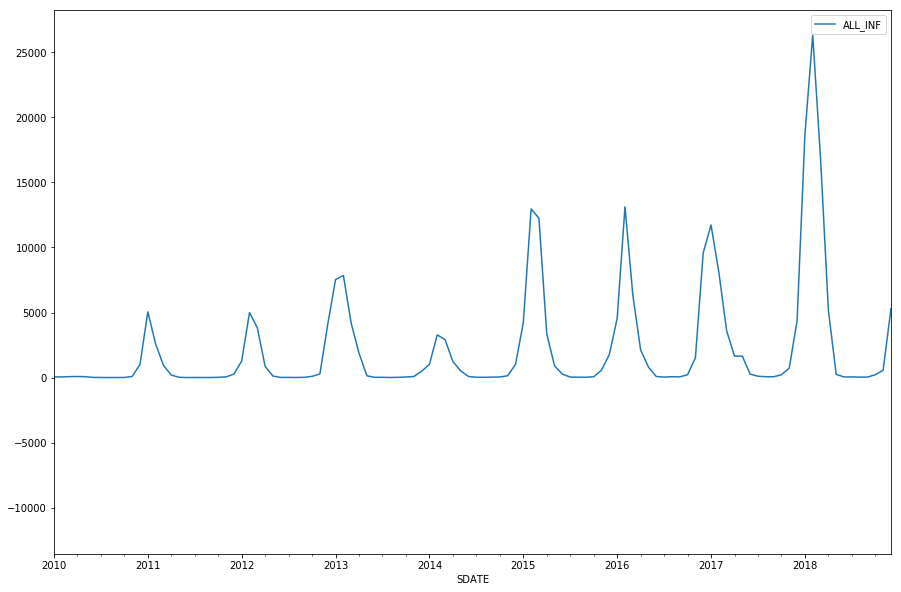

In [56]:
#-----Visualize raw data stuff-----
pb.close()
fig, ax = pb.subplots(1,1,figsize=(15,10));

#Plot raw data
pdData.plot(ax=ax,label="INF")

#Plot raw data with monthly trend removed (already done in the csv file)
pb.plot(diff)

#Plot yearly average
#pdDataYearly.plot(x='year',y='mean',ax=ax,label="mean")

#Fit polynomial to data
p2 = np.polyfit(x=pdData[0],y=pdData[4],deg=2)
p3 = np.polyfit(x=pdData[2],y=pdData[4],deg=3)
poly2 = np.poly1d(p2);
poly3 = np.poly1d(p3);
pb.plot(pdData[2],poly2(pdData[2]),label="polyfit")

pb.legend()
pb.title("Raw data")
pb.ylabel("ppm CO2")
pb.show()
print("\n\nSeems like a polynomial fit or removing yearly average might "
      "be the best approaches.\n\n")


#-----Visualize residuals-----
fig2, ax2 = pb.subplots(1,2,figsize=(15,5),sharey=True)
ax2[0].plot(pdData[2],pdData[4]-poly2(pdData[2]))
ax2[0].set_title("Residual using 2nd degree polynomial.")
ax2[1].plot(pdData[2],pdData[4]-poly3(pdData[2]))
ax2[1].set_title("Residual using 3rd degree polynomial.")
ax2[0].set_ylabel("residual")
ax2[0].set_xlabel('year')
ax2[1].set_xlabel('year')


#Plot yearly mean vector, using year not month average
yearly_mean = np.ones((12,len(pdDataYearly)));
yearly_mean = (yearly_mean*(pdDataYearly['mean'].values.reshape(1,-1))).T.ravel();
yearly_mean_poly = poly2(pdData[2]);
fig3, ax3 = pb.subplots(1,1,figsize=(15,5));
ax3.plot(pdData[2],pdData[4]-yearly_mean);
ax3.set_title("Residual after removing yearly average.")
ax3.set_ylabel("residual")
ax3.set_xlabel('year')
pb.show();

res2poly = np.sum(np.abs(pdData[4]-poly2(pdData[2])));
resYearlyAvg = np.sum(np.abs(pdData[4]-yearly_mean));

print("\nSum of residuals: 2nd deg. poly: {}, yearly mean: {}"
      "\n\nAs we can see, removing the yearly average is slight better than"
      "fitting the polynomial.\n\n".format(round(res2poly),round(resYearlyAvg)))

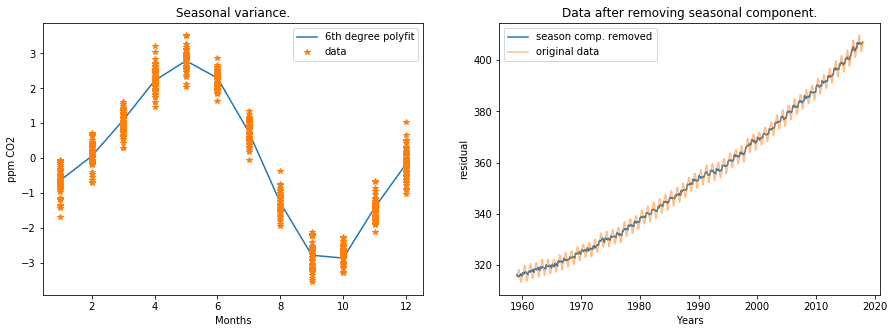


There definitely is a seasonal component in this time series,
and the results gets better if we remove the yearly one.




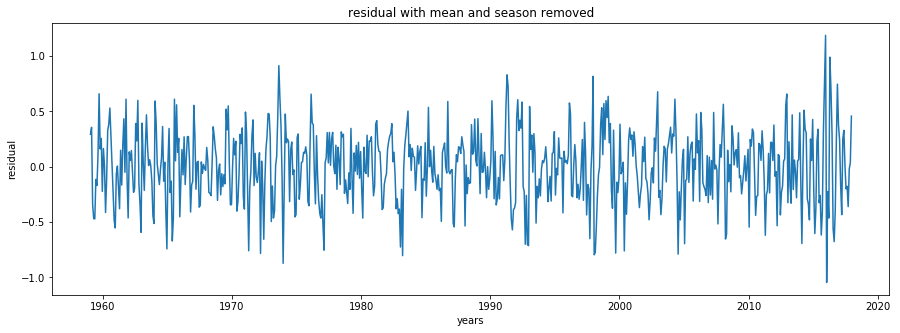


The residual seems to be more random than before which is good,
the more prevalent cyclic component is removed, but there still
seems to be some other underlying cyclic component,
the peaks of the residual still seems to occur somewhat periodically.


In [12]:
#-----Removing seasonal component using 4th degree polynomial-----
p_season = np.polyfit(pdData[1],pdData[4]-yearly_mean,deg=6)
poly_season = np.poly1d(p_season);
fig4, ax4 = pb.subplots(1,2,figsize=(15,5));
ax4[0].plot(range(1,13),poly_season(range(1,13)),label="6th degree polyfit")
ax4[0].plot(pdData[1],pdData[4]-yearly_mean,'*',label="data")
ax4[0].set_title("Seasonal variance.")
ax4[0].set_xlabel("Months")
ax4[0].set_ylabel("ppm CO2")

ax4[1].plot(pdData[2],pdData[4]-poly_season(pdData[1]),label="season comp. removed")
ax4[1].plot(pdData[2],pdData[4],alpha=0.5,label="original data")
ax4[1].set_title("Data after removing seasonal component.")
ax4[1].set_xlabel("Years")
ax4[1].set_ylabel("residual")
ax4[0].legend()
ax4[1].legend()
pb.show()

print("\nThere definitely is a seasonal component in this time series,"
      "\nand the results gets better if we remove the yearly one.\n\n")

fig5, ax5 = pb.subplots(1,1,figsize=(15,5));
ax5.plot(pdData[2],pdData[4]-yearly_mean-poly_season(pdData[1]))
ax5.set_title("residual with mean and season removed")
ax5.set_xlabel("years")
ax5.set_ylabel("residual")
pb.show()

print("\nThe residual seems to be more random than before which is good,"
      "\nthe more prevalent cyclic component is removed, but there still\n"
      "seems to be some other underlying cyclic component,\n"
      "the peaks of the residual still seems to occur somewhat periodically.")

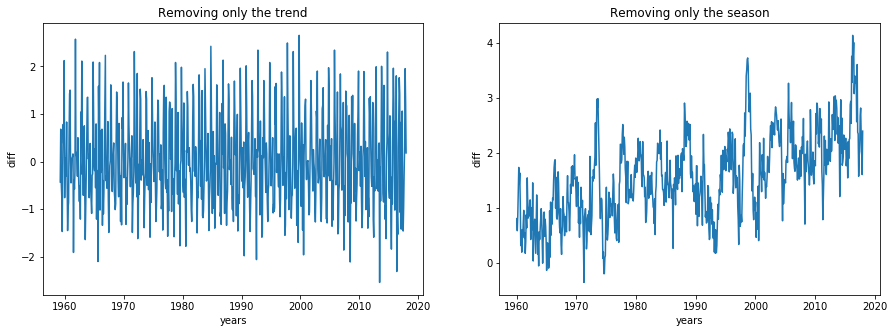

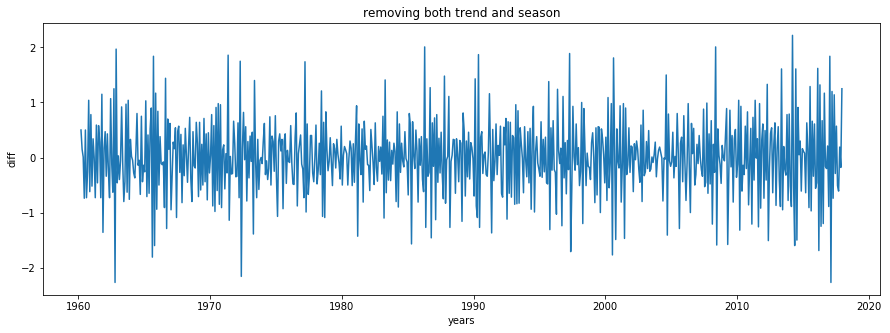



There still seems to be some cyclic component left, although it's much better.


In [5]:
#-----Removing seasonal component and trend using differencing-----
fig, ax = pb.subplots(1,2,figsize=(15,5));
ax[0].plot(pdData[2],pdData[4].diff(1).diff(1))
ax[1].plot(pdData[2],pdData[4].diff(12))
ax[0].set_title("Removing only the trend")
ax[1].set_title("Removing only the season")
ax[0].set_ylabel("diff")
ax[1].set_ylabel("diff")
ax[0].set_xlabel("years")
ax[1].set_xlabel("years")
pb.show()

fig, ax = pb.subplots(1,1,figsize=(15,5));
ax.plot(pdData[2],pdData[4].diff(12).diff(1).diff(1))
ax.set_title("removing both trend and season")
ax.set_ylabel("diff")
ax.set_xlabel("years")
pb.show()

print("\n\nThere still seems to be some cyclic component left,"
      " although it's much better.")

## Doing all of the above using libraries

/Users/Marcus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


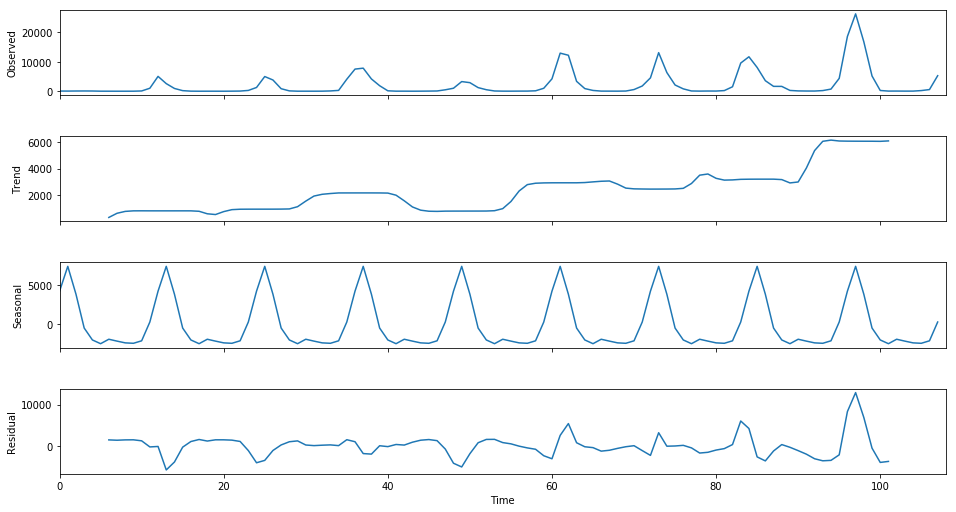

In [44]:
#Create a trend, seasonal decomposition and residual using statsmodels
decomp = smt.seasonal_decompose(pdData.as_matrix(),freq=12)

fig = decomp.plot()  
fig.set_size_inches(15, 8)
pb.show()

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

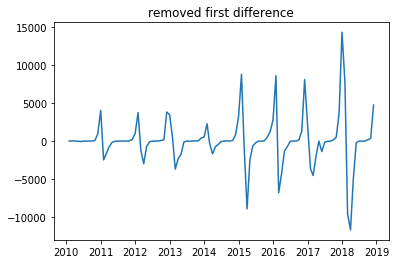

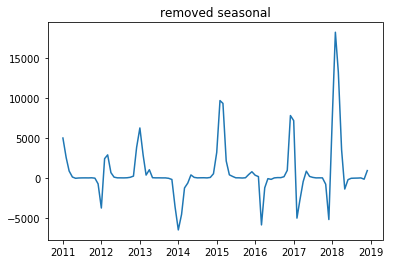

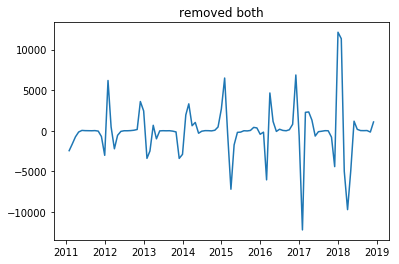

ADF Statistic: -2.897296
p-value: 0.045663
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586


In [52]:
#Basically the same as before when we used diff()
first_diff = pdData-pdData.shift(1)
pb.plot(first_diff)
pb.title("removed first difference")
pb.show()

seasonal_diff = pdData-pdData.shift(12)
pb.plot(seasonal_diff)
pb.title("removed seasonal")
pb.show()

true_diff = first_diff-first_diff.shift(12)
pb.plot(true_diff)
pb.title("removed both")
pb.show()



result = adfuller(seasonal_diff['ALL_INF'][12:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))